In [12]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import IPython.display as ipd
import librosa
import librosa.display

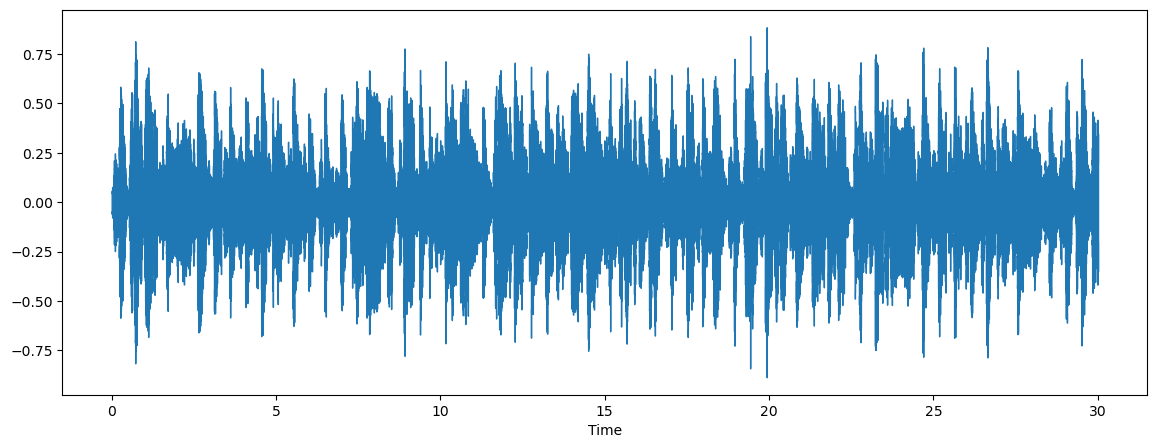

In [14]:
filename='/kaggle/input/gtzan-genre-collection/genres/blues/blues.00000.au'
plt.figure(figsize=(14,5))
data,sample_rate=librosa.load(filename)
librosa.display.waveshow(data,sr=sample_rate)
ipd.Audio(filename)

The function returns two values: 
* The audio signal, represented as a one-dimensional NumPy array. 
* The sampling rate of the audio file, which is the number of samples per second used to represent the signal. 

In [16]:
data,sample_rate

(array([ 0.00732422,  0.01660156,  0.00762939, ..., -0.05560303,
        -0.06106567, -0.06417847], dtype=float32),
 22050)

In [11]:
# define the path to the GTZAN dataset
data_path = '/kaggle/input/gtzan-genre-collection/genres/'

# define the list of genres
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

# define a function to extract features from an audio file
def extract_features(file_path):
    # load audio file using librosa
    signal, sr = librosa.load(file_path)
    # extract features using librosa
    mfccs = librosa.feature.mfcc(y=signal, sr=sr)
    spectral_centroid = librosa.feature.spectral_centroid(y=signal, sr=sr)
    spectral_rolloff = librosa.feature.spectral_rolloff(y=signal, sr=sr)
    # concatenate features into a single array
    features = np.concatenate((mfccs.mean(axis=1), np.array([spectral_centroid.mean()]), np.array([spectral_rolloff.mean()])))
    return features

In [2]:
# define a custom dataset class for the GTZAN dataset
class GTZANDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        x = torch.Tensor(self.data[index])
        y = torch.Tensor(self.labels[index])
        return x, y

In [3]:
# load the dataset into memory
data = []
labels = []
for genre in genres:
    genre_path = os.path.join(data_path, genre)
    for file_name in os.listdir(genre_path):
        file_path = os.path.join(genre_path, file_name)
        features = extract_features(file_path)
        data.append(features)
        labels.append(genre)

In [4]:
#!pip install librosa

In [5]:
# convert the labels to categorical format
le = LabelEncoder()
labels = le.fit_transform(labels)
labels = torch.LongTensor(labels)

# split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2)

In [6]:
# create dataloaders for the training and testing sets
train_dataset = GTZANDataset(X_train, y_train)
test_dataset = GTZANDataset(X_test, y_test)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [7]:
# define the neural network model for genre classification

import torch.nn as nn
import torch.nn.functional as F

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(22, 256)   # increase to 256
        self.fc2 = nn.Linear(256, 128)  # increase to 128
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 22)  # Reshape input tensor
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [8]:
model = MyModel()

# define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
# Train the model for 1000 epochs
train_acc_list = []
test_acc_list = []
num_epochs = 1000
for epoch in range(num_epochs):
    train_loss = 0.0
    train_acc = 0.0
    for i, (inputs, labels) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        train_acc += torch.sum(preds == labels.data)
    train_loss = train_loss / len(train_dataloader.dataset)
    train_acc = train_acc / len(train_dataloader.dataset)
    train_acc_list.append(train_acc)
    print('Epoch [{}/{}], Train Loss: {:.4f}, Train Acc: {:.4f}'.format(epoch+1, num_epochs, train_loss, train_acc))
    
    # Evaluate the model on test set
    model.eval()
    test_loss = 0.0
    test_acc = 0.0
    for i, (inputs, labels) in enumerate(test_dataloader):
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        test_acc += torch.sum(preds == labels.data)
    test_loss = test_loss / len(test_dataloader.dataset)
    test_acc = test_acc / len(test_dataloader.dataset)
    test_acc_list.append(test_acc)
    print('Epoch [{}/{}], Test Loss: {:.4f}, Test Acc: {:.4f}'.format(epoch+1, num_epochs, test_loss, test_acc))


Epoch [1/1000], Train Loss: 80.5267, Train Acc: 0.0875
Epoch [1/1000], Test Loss: 22.5979, Test Acc: 0.1300
Epoch [2/1000], Train Loss: 24.6070, Train Acc: 0.1513
Epoch [2/1000], Test Loss: 20.5481, Test Acc: 0.1400
Epoch [3/1000], Train Loss: 13.9944, Train Acc: 0.1787
Epoch [3/1000], Test Loss: 10.3499, Test Acc: 0.1300
Epoch [4/1000], Train Loss: 7.5298, Train Acc: 0.2050
Epoch [4/1000], Test Loss: 8.0594, Test Acc: 0.2200
Epoch [5/1000], Train Loss: 8.3245, Train Acc: 0.1963
Epoch [5/1000], Test Loss: 7.6753, Test Acc: 0.2450
Epoch [6/1000], Train Loss: 7.4748, Train Acc: 0.2125
Epoch [6/1000], Test Loss: 5.7445, Test Acc: 0.2650
Epoch [7/1000], Train Loss: 4.5476, Train Acc: 0.2675
Epoch [7/1000], Test Loss: 5.8807, Test Acc: 0.2250
Epoch [8/1000], Train Loss: 4.9226, Train Acc: 0.2788
Epoch [8/1000], Test Loss: 5.1659, Test Acc: 0.3250
Epoch [9/1000], Train Loss: 5.7651, Train Acc: 0.2525
Epoch [9/1000], Test Loss: 5.8299, Test Acc: 0.2200
Epoch [10/1000], Train Loss: 5.7610, Tra

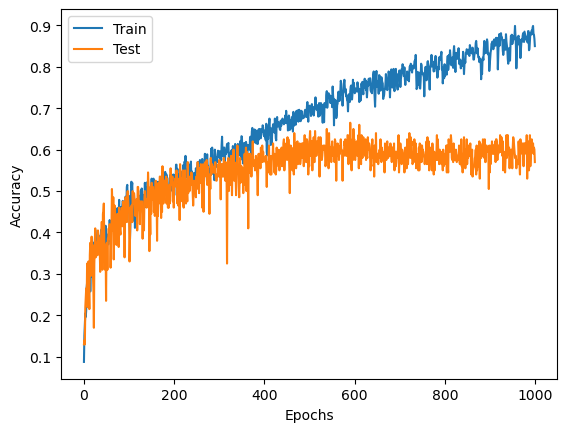

In [10]:
import matplotlib.pyplot as plt

# plot training and testing accuracy
plt.plot(train_acc_list, label='Train')
plt.plot(test_acc_list, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
